In [42]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from hpelm import ELM
from tensorflow.keras.models import Sequential
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, auc, accuracy_score
warnings.filterwarnings("ignore")

In [21]:
data = pd.read_csv("Group_14_data_cleaned.csv")
# Split the data into training and testing sets
X = data.drop(['Auction_ID', 'Class', 'Bidder_ID'], axis=1)
y = data['Class']

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base models
rf = RandomForestClassifier(random_state=42)
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma=1, random_state=42))
lr = LogisticRegression(random_state=42)
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=7))
mlp = MLPClassifier(hidden_layer_sizes=(64,64), random_state=42)


# Defining the meta-model
meta_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)

# Defining the stacking
stacking = StackingClassifier(classifiers=[rf, svm, lr, knn, mlp],
                              meta_classifier=meta_model)

# Fitting the stacking model
stacking.fit(X_train, y_train)

Accuracy: 0.9960474308300395


In [39]:
# Use the trained classifier to predict the class labels for the test data
y_pred = stacking.predict(X_test)
score = stacking.score(X_test, y_test)
print("Accuracy:", score)
# Evaluate the classifier's performance on the test data
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9960474308300395
[[1131    2]
 [   3  129]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1133
           1       0.98      0.98      0.98       132

    accuracy                           1.00      1265
   macro avg       0.99      0.99      0.99      1265
weighted avg       1.00      1.00      1.00      1265



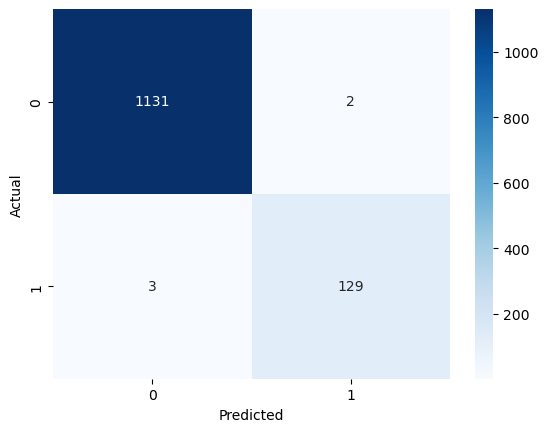

In [43]:
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Comparing each model with the Ensemble

In [32]:
# Best hyperparameters:  {'C': 1.0, 'gamma': 0.1, 'kernel': 'linear'}
# {'C': 9.087699346650997, 'gamma': 1.0163457603417565, 'kernel': 'rbf'
# Define the SVM model
svm_model = SVC(kernel='rbf', C=9.0877, gamma=1.016345)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Define the logistic regression model
lr_model = LogisticRegression(C=1, max_iter=200)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

# Best hyperparameters:  
# {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
# Define the random forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, min_samples_leaf=1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)


# Define the KNN model
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

## ELM
# Convert input data to numpy arrays
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values
# Initialize the ELM model with the desired parameters
model = ELM(X_train.shape[1], 1, classification="c", batch=64, accelerator="cpu", precision="single")
model.add_neurons(512, "tanh")
# Train the model
model.train(X_train_np, y_train_np)


# Test the model
y_pred_ELM = model.predict(X_test_np)
y_pred_ELM = np.round(y_pred_ELM)
acc_ELM = accuracy_score(y_test_np, y_pred_ELM)

## Neural Network

# Define the neural network model
def create_model(num_layers=1, num_neurons=10):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
    for i in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = create_model(num_layers=2, num_neurons=64)
model.fit(X_train, y_train, epochs=50, verbose=2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, verbose=2)
# Use the trained classifier to predict the class labels for the test data
y_pred_nn = model.predict(X_test)
y_pred_nn = np.round(y_pred_nn)

acc_nn = accuracy_score(y_test, y_pred_nn)

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Epoch 1/50
158/158 - 1s - loss: 0.1883 - accuracy: 0.9419 - 842ms/epoch - 5ms/step
Epoch 2/50
158/158 - 0s - loss: 0.0473 - accuracy: 0.9773 - 221ms/epoch - 1ms/step
Epoch 3/50
158/158 - 0s - loss: 0.0425 - accuracy: 0.9808 - 211ms/epoch - 1ms/step
Epoch 4/50
158/158 - 0s - loss: 0.0403 - accuracy: 0.9814 - 207ms/epoch - 1ms/step
Epoch 5/50
158/158 - 0s - loss: 0.0392 - accuracy: 0.9840 - 205ms/epoch - 1ms/step
Epoch 6/50
158/158 - 0s - loss: 0.0368 - accuracy: 0.9824 - 206ms/epoch - 1ms/step
Epoch 7/50
158/158 - 0s - loss: 0.0380 - accuracy: 0.9830 - 205ms/epoch - 1ms/step
Epoch 8/50
158/158 - 0s - loss: 0.0348 - accuracy: 0.9846 - 221ms/epoch - 1ms/step
Epoch 9/50
158/158 - 0s - loss: 0.0329 - accuracy: 0.9856 - 241ms/epoch - 2ms/step
Epoch 10/50
158/158 - 0s - loss: 0.0318 - accuracy: 0.9867 - 206ms/epoch - 1ms/step
Epoch 11/50
158/158 - 0s - loss: 0.0297 - accur

Epoch 46/50
158/158 - 0s - loss: 0.0040 - accuracy: 0.9988 - 217ms/epoch - 1ms/step
Epoch 47/50
158/158 - 0s - loss: 0.0113 - accuracy: 0.9978 - 248ms/epoch - 2ms/step
Epoch 48/50
158/158 - 0s - loss: 0.0040 - accuracy: 0.9990 - 220ms/epoch - 1ms/step
Epoch 49/50
158/158 - 0s - loss: 0.0024 - accuracy: 0.9992 - 201ms/epoch - 1ms/step
Epoch 50/50
158/158 - 0s - loss: 3.1073e-04 - accuracy: 1.0000 - 211ms/epoch - 1ms/step
40/40 [==============================] - 0s 1ms/step


In [36]:
# Evaluate the stacking model
acc_Ens = stacking.score(X_test, y_test)
print("Accuracy:", acc_Ens)


Accuracy: 0.9960474308300395


In [38]:
# Compare the accuracy of each model with the Ensemble model
print("Accuracy of Ensemble: {:.3f}".format(acc_Ens))
print("Accuracy of SVM: {:.3f}".format(acc_svm))
print("Accuracy of logistic regression: {:.3f}".format(acc_lr))
print("Accuracy of random forest: {:.3f}".format(acc_rf))
print("Accuracy of KNN: {:.3f}".format(acc_knn))
print("Accuracy of ELM: {:.3f}".format(acc_ELM))
print("Accuracy of nn: {:.3f}".format(acc_nn))

Accuracy of Ensemble: 0.996
Accuracy of SVM: 0.991
Accuracy of logistic regression: 0.975
Accuracy of random forest: 0.993
Accuracy of KNN: 0.986
Accuracy of ELM: 0.987
Accuracy of nn: 0.997
